<a href="https://colab.research.google.com/github/kdh1647/Bumblebee2/blob/master/513Y001_ARIMA_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#학습과 테스트 모델 분리
from sklearn.model_selection import train_test_split

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.7 MB/s 
     |████████████████████████████████| 9.9 MB 42.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [1]:
#ARIMA, STATIONARY 학습 및 분석을 위한 Library
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from statsmodels.tsa.arima_model import ARIMA    #old번전
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX    #auto_arima로 대체
from pmdarima.arima import auto_arima

from statsmodels.tools.eval_measures import rmse

import itertools    #배열 경우의 수 만큼 병합

In [7]:
## 데이터 Read  10년치 경제심리 지수
raw_df = pd.read_csv('https://raw.githubusercontent.com/kdh1647/Bumblebee2/master/513Y001.csv', encoding='CP949')

In [8]:
raw_df.head(5)

,Unnamed: 0,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,ITEM_CODE2,ITEM_NAME2,ITEM_CODE3,ITEM_NAME3,ITEM_CODE4,ITEM_NAME4,UNIT_NAME,TIME,DATA_VALUE
0,0,513Y001,6.3. 경제심리지수,E1000,경제심리지수(원계열),NaN,NaN,NaN,NaN,NaN,NaN,NaN,201301,94.5
1,1,513Y001,6.3. 경제심리지수,E1000,경제심리지수(원계열),NaN,NaN,NaN,NaN,NaN,NaN,NaN,201302,96.3
2,2,513Y001,6.3. 경제심리지수,E1000,경제심리지수(원계열),NaN,NaN,NaN,NaN,NaN,NaN,NaN,201303,98.3
3,3,513Y001,6.3. 경제심리지수,E1000,경제심리지수(원계열),NaN,NaN,NaN,NaN,NaN,NaN,NaN,201304,97.9
4,4,513Y001,6.3. 경제심리지수,E1000,경제심리지수(원계열),NaN,NaN,NaN,NaN,NaN,NaN,NaN,201305,97.3


In [9]:
data = raw_df[['TIME', 'DATA_VALUE']]    #필요컬럼만 추출

In [10]:
data.TIME = pd.to_datetime(data['TIME'].astype(str) + '01', format='%Y-%m-%d')    #년월을 날짜형태로 변형 202003 -> 2022-03-01

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
data

,TIME,DATA_VALUE
0,2013-01-01,94.5
1,2013-02-01,96.3
2,2013-03-01,98.3
3,2013-04-01,97.9
4,2013-05-01,97.3
...,...,...
112,2022-05-01,106.7
113,2022-06-01,102.5
114,2022-07-01,97.8
115,2022-08-01,99.3


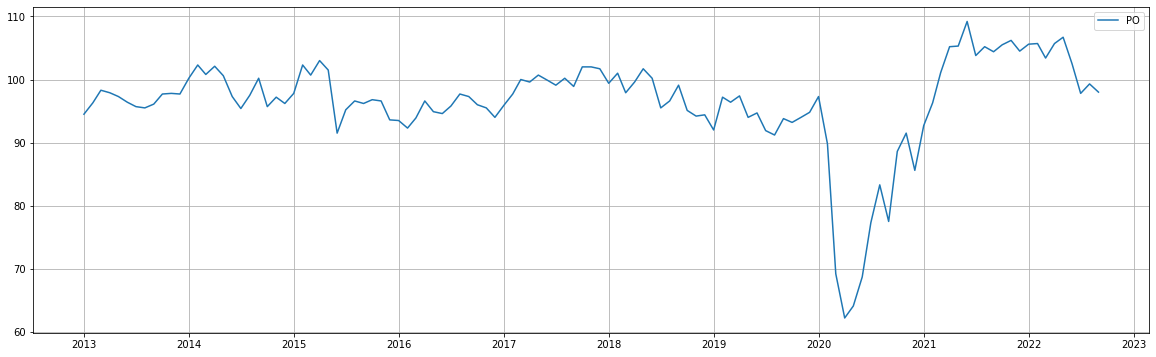

In [13]:
plt.figure(figsize=(20,6))
plt.plot(data['TIME'], data['DATA_VALUE'], label='PO')
plt.grid()
plt.legend(loc='best')

plt.show()

### 02. 데이터 추세 분해

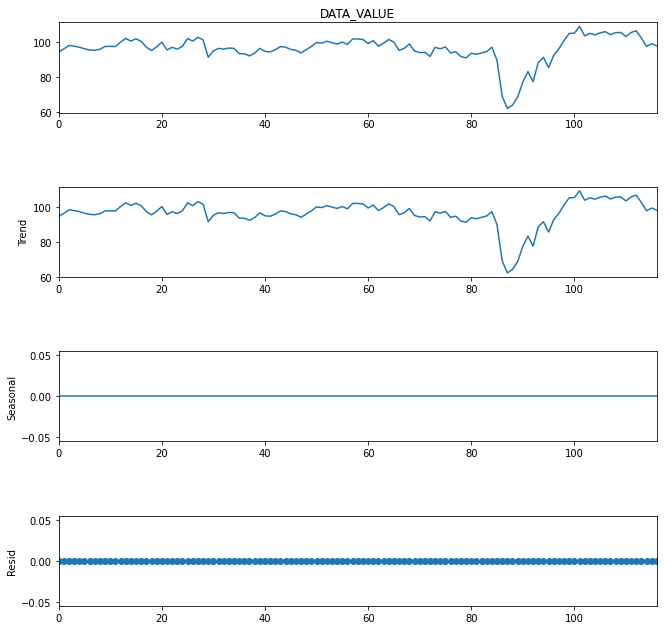

In [14]:
decomposion = sm.tsa.seasonal_decompose(data['DATA_VALUE'], model='additive', period=1)
fig = decomposion.plot()
fig.set_size_inches(10, 10)
plt.show()

### 03. 시계열 데이터 Stationary (정상성) 분석

###     시간에 따라 평균이나 분산이 일정한지 파악 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


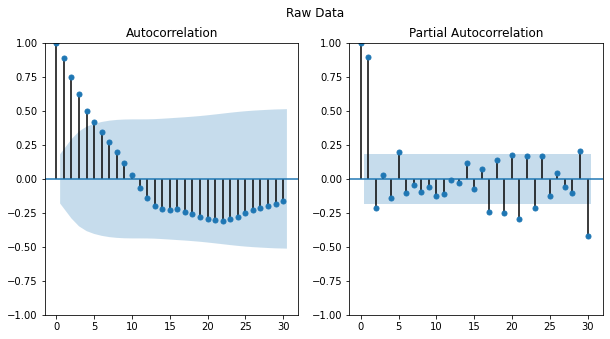

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(data['DATA_VALUE'].values.squeeze(), lags=30, ax=ax[0]);
sm.graphics.tsa.plot_pacf(data['DATA_VALUE'].values.squeeze(), lags=30, ax=ax[1]);

In [16]:
result = adfuller(data['DATA_VALUE'])
format(result[1], '.23f')

'0.03170639966400138481939'

### 0.05 이하 이므로 정상성이 있다, 즉 정상적인 시계열 데이터 라고 판단

### 04. 만약 0.05 이상의 비정상성 데이터의 경우 차분(Differencing) 처리

In [18]:
# 학습(0.8)과 테스트(0.2) 데이터 분리
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [20]:
diff_train_data = train_data.copy()   # 차분 테스트를 위해 차분용 데이터 프레임 별도 준비

In [21]:
#1차 차분
diff_train_data = diff_train_data['DATA_VALUE'].diff()

In [23]:
diff_train_data = diff_train_data.dropna()    #누락데이터(NaN) 제거

### 차분 이 후 정상성 파악

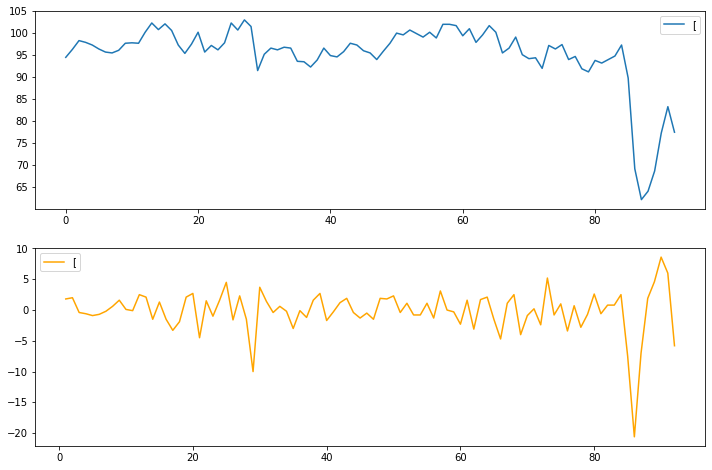

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(train_data['DATA_VALUE'])
plt.legend('[Raw Data (Nonstationary)]')

plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend('[Diff Raw Data (Stationary)]')

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


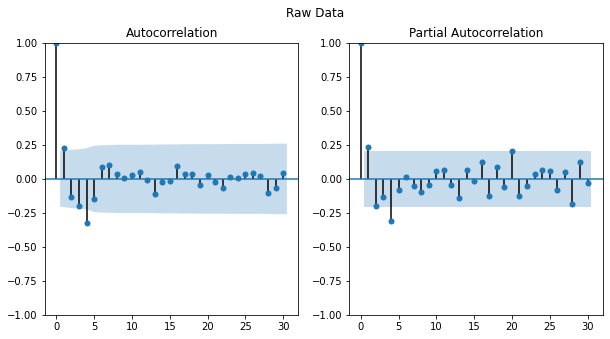

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0]);
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]);

In [26]:
result = adfuller(diff_train_data.values)
format(result[1], '.23f')

'0.00000000011223558276884'

### 05. ARIMA 

https://blog.naver.com/tjgml1343/222077619748

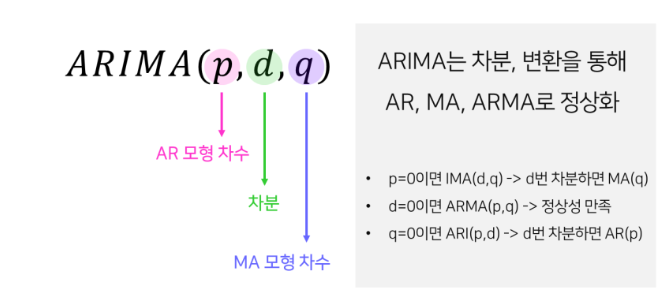

In [27]:
train_data = train_data.set_index('TIME')

In [28]:
test_data = test_data.set_index('TIME')

In [29]:
model = ARIMA(train_data.values, order=(1, 1, 1))      # 차분하지 않은 원본 데이터 (중요)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -241.784
Date:                Thu, 10 Nov 2022   AIC                            489.568
Time:                        07:32:52   BIC                            497.133
Sample:                             0   HQIC                           492.621
                                 - 93                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2751      0.316     -0.872      0.383      -0.894       0.343
ma.L1          0.5745      0.298      1.929      0.054      -0.009       1.158
sigma2        11.2103      1.266      8.857      0.000       8.730      13.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               265.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                            -1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 06. 가장 낮은 AIC 값을 위한 p, q , d 값 찾기

#### p: AR모형의 leg 값, d: 차분 횟수, q: MA모형의 lag값

In [30]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))   # p, q, d 수에 따른 조합

In [31]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [32]:
aic = []

for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic, 2))

ARIMA: (0, 0, 0) >> AIC : 643.25
ARIMA: (0, 0, 1) >> AIC : 559.77


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (0, 0, 2) >> AIC : 589.44
ARIMA: (0, 1, 0) >> AIC : 493.73
ARIMA: (0, 1, 1) >> AIC : 488.41
ARIMA: (0, 1, 2) >> AIC : 489.01
ARIMA: (1, 0, 0) >> AIC : 500.83
ARIMA: (1, 0, 1) >> AIC : 493.0
ARIMA: (1, 0, 2) >> AIC : 494.93
ARIMA: (1, 1, 0) >> AIC : 490.57
ARIMA: (1, 1, 1) >> AIC : 489.57
ARIMA: (1, 1, 2) >> AIC : 486.18
ARIMA: (2, 0, 0) >> AIC : 494.52
ARIMA: (2, 0, 1) >> AIC : 494.91


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA: (2, 0, 2) >> AIC : 496.82
ARIMA: (2, 1, 0) >> AIC : 488.41
ARIMA: (2, 1, 1) >> AIC : 484.23
ARIMA: (2, 1, 2) >> AIC : 483.04


In [33]:
for i in range(len(pdq)):
    if(aic[i]  == min(aic)):
        opti = pdq[i]

In [36]:
opti

(2, 1, 2)

In [34]:
# AIC값이 가장 낮은 p=2, d=1, q=2 
model = ARIMA(train_data.values, order=opti)      # 차분하지 않은 원본 데이터
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -236.522
Date:                Thu, 10 Nov 2022   AIC                            483.045
Time:                        07:34:23   BIC                            495.654
Sample:                             0   HQIC                           488.134
                                 - 93                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3238      0.234      5.665      0.000       0.866       1.782
ar.L2         -0.8769      0.260     -3.370      0.001      -1.387      -0.367
ma.L1         -1.1788      0.274     -4.308      0.000      -1.715      -0.642
ma.L2          0.5891      0.320      1.843      0.065      -0.037       1.216
sigma2         9.9056      0.799     12.391      0.000       8.339      11.472
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               572.07
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.59   Skew:                            -2.40
Prob(H) (two-sided):                  0.01   Kurtosis:                        14.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# 테스트 데이터 셋 예측
prediction  = model_fit.forecast(len(test_data))

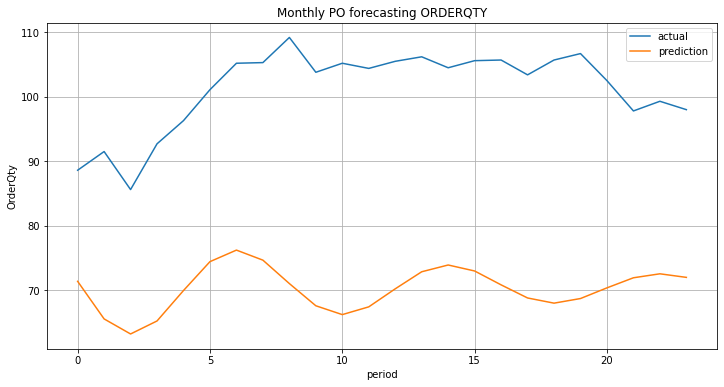

In [38]:
plt.figure(figsize=(12,6))
plt.title('Monthly PO forecasting ORDERQTY')
plt.ylabel('OrderQty')
plt.xlabel('period')
plt.plot(test_data.values, label='actual')
plt.plot(prediction, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [40]:
# MAPE(Mean Absolut Percentage Error) 평균 절대 백분율 오차로 모델 오차율 검증
def MAPE_Val(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [41]:
MAPE_Val(prediction, test_data['DATA_VALUE'].values)

0.3044366155129875

### 07. AUTO ARIMA
### Seasonal을 이용한 auto_arima 모델
#### pqd 외 계절적 성분 S가 추가
#### 지정 구간내에서 최적값을 자동으로 찾아 모델

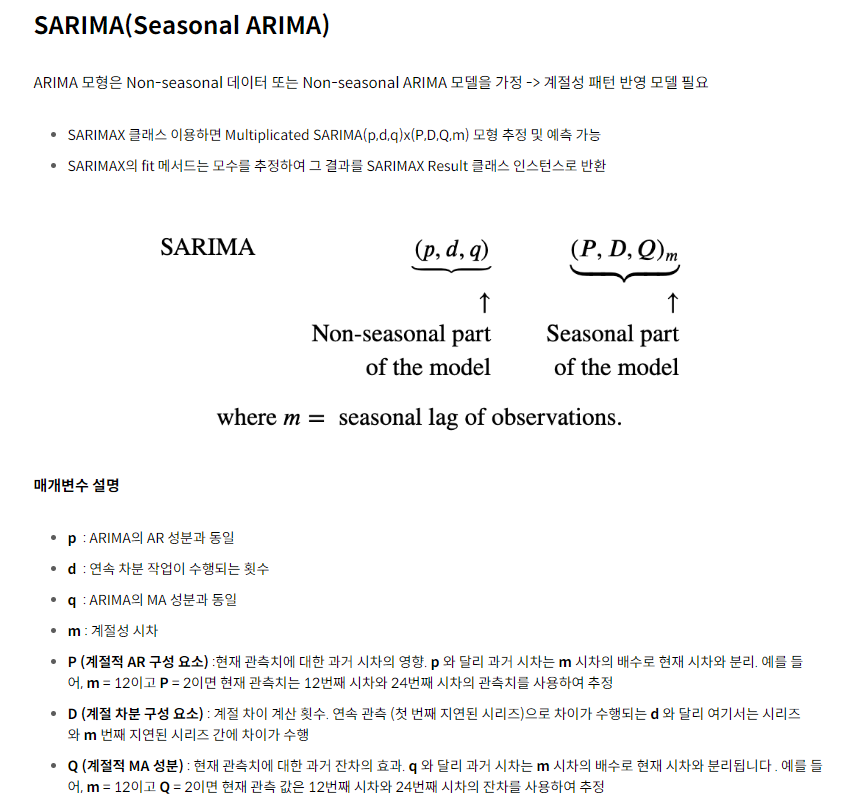

In [42]:
# AUTO ARIMA 는 pqd 와 PDQ 값을 범위 안에 자동 탐색하여 최적값 도축
auto_arima_model = auto_arima(train_data, start_p=0, start_q=0, max_p=3, max_q=3, 
                             m=12, seasonal=True,    #계절변동은 1년
                             d=1, D=1,
                             max_P=3, max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False) 

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=466.109, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=455.833, Time=0.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=457.719, Time=0.67 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=459.684, Time=1.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=459.170, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=457.726, Time=0.24 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=459.544, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=459.723, Time=0.79 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=4.37 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=459.051, Time=0.44 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=460.939, Time=1.87 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=462.936, Time=2.47 sec
 ARIMA(0,1,1)(0,1,0)[12]  

In [43]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   93
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -216.328
Date:                              Thu, 10 Nov 2022   AIC                            444.657
Time:                                      07:43:10   BIC                            458.949
Sample:                                  01-01-2013   HQIC                           450.387
                                       - 09-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2673      0.270      4.702      0.000       0.739       1.796
ar.L2         -0.8521      0.300     -2.842      0.004      -1.440      -0.264
ma.L1         -1.0753      0.338     -3.179      0.001      -1.738      -0.412
ma.L2          0.5160      0.423      1.219      0.223      -0.314       1.346
ma.S.L12      -0.7113      0.234     -3.040      0.002      -1.170      -0.253
sigma2        11.5025      1.487      7.735      0.000       8.588      14.417
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               161.25
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0].values
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

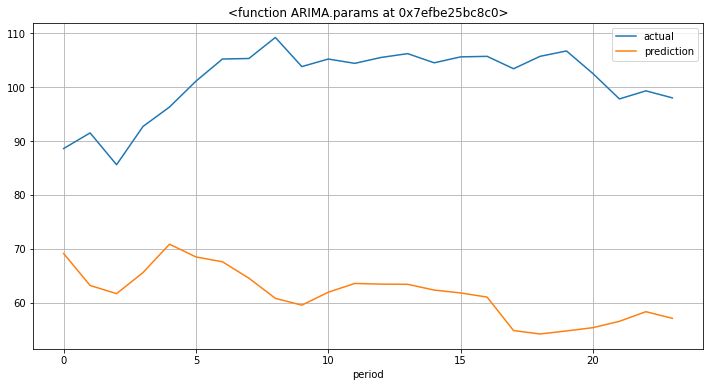

In [45]:
plt.figure(figsize=(12,6))
plt.title(auto_arima_model.params)
plt.xlabel('period')
plt.plot(test_data['DATA_VALUE'].values, label='actual')
plt.plot(predicted_value, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [46]:
MAPE_Val(predicted_value, test_data['DATA_VALUE'].values)

0.38744629471641767